In [1]:
using Integrals
using SpecialFunctions
using Base.Threads
using Glob
using DataFrames
using CSV
using CairoMakie
using LaTeXStrings
using Polynomials
using Statistics

CairoMakie.activate!(inline=true)

In [2]:
CairoMakie.activate!(inline=true)
custom_theme = Theme(
    fontsize = 8,
    linewidth = 1.5,
    fonts = (; regular = "Helvetica"),
    Axis = (
        spinewidth = 1,
        xgridvisible = false,
        ygridvisible = false,
        topspinevisible = false,
        rightspinevisible = false,
        xtickwidth = 1,
        xticksize = 2,
        ytickwidth = 1,
        yticksize = 2,
    ),
    Colorbar = (
        spinewidth = 1,
        tickwidth = 1,
        ticksize = 2,
    ),
    Legend = (
        framevisible = false,
    )
)
set_theme!(custom_theme)

In [3]:
function mrna(r,α,kp)
    function f(u,p)
        ϕ₁ = u[1]; r₁ = u[2]
        ϕ = p[1]; r = p[2]; σ = p[3]; d = p[4]; α = p[5]
        return r₁*besselk(0,α*sqrt(r^2+r₁^2-2*r*r₁*(cos(ϕ)*cos(ϕ₁)+sin(ϕ)*sin(ϕ₁))))*exp(-(r₁^2-2*r₁*cos(ϕ₁)*d+d^2)/(2*σ^2))
    end
    d = 0; ϕ = 0; σ = 2.5; χ = -0.1; Mc = Mm = 1; cm = 3.5; cp = 4.5
    domain = ([0,0], [2*π,Inf])
    p = (ϕ, r, σ, d, α)
    prob = IntegralProblem(f, domain, p)
    sol = solve(prob, HCubatureJL(), reltol = 1e-6, abstol = 1e-6)
    m = sol.u * kp * cm / (2*π*Mm)
    return m
end

mrna (generic function with 1 method)

In [4]:
function getkp(α1,α2,kp)
    kp * mrna(0, α1, 1)/mrna(0, α2, 1)
end

getkp (generic function with 1 method)

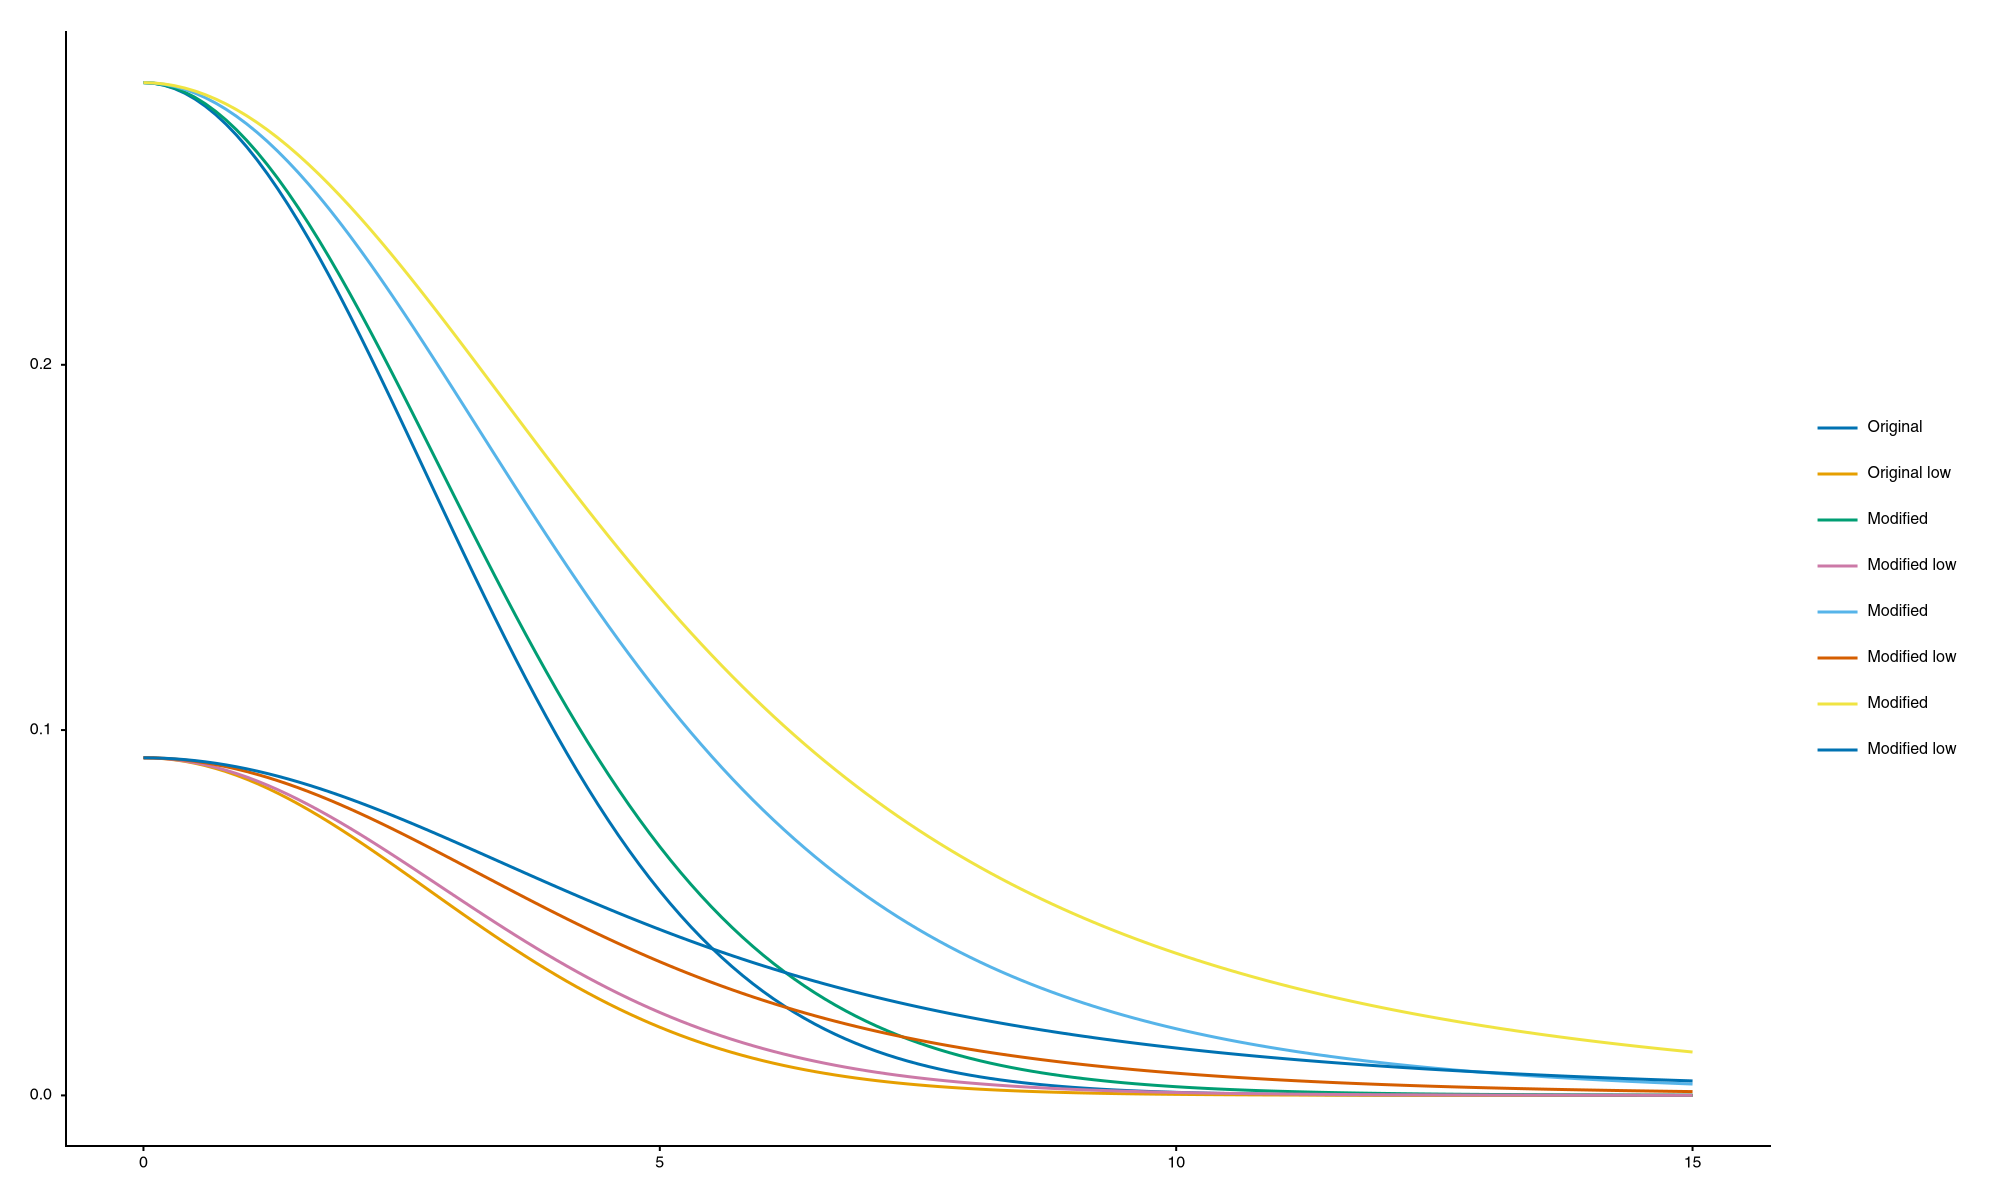

In [5]:
fig = Figure(size = (1000, 600))
ax1 = Axis(fig[1, 1])
x = 0:0.1:15
α = 1
lines!(ax1, x, mrna.(x, α, 0.1),label="Original")
lines!(ax1, x, mrna.(x, α, 0.1/3),label="Original low")
α = 1/sqrt(2)
lines!(ax1, x, mrna.(x, α, getkp(1,α,0.1)),label="Modified")
lines!(ax1, x, mrna.(x, α, getkp(1,α,0.1)/3),label="Modified low")
α = 1/sqrt(10)
lines!(ax1, x, mrna.(x, α, getkp(1,α,0.1)),label="Modified")
lines!(ax1, x, mrna.(x, α, getkp(1,α,0.1)/3),label="Modified low")
kd = 1/25
α = sqrt(kd/1)
lines!(ax1, x, mrna.(x, α, getkp(1,α,0.1)),label="Modified")
lines!(ax1, x, mrna.(x, α, getkp(1,α,0.1)/3),label="Modified low")

Legend(fig[1, 2], ax1)
fig

In [6]:
mrnaprofile = mrna.(x, α, 0.1)

151-element Vector{Float64}:
 2.0120431298863393
 2.011368967051201
 2.009349295890232
 2.0059915666151076
 2.001302503461458
 1.9952963560826829
 1.9879897415146544
 1.9793999762490038
 1.9695600827333206
 1.9584873075272358
 ⋮
 0.10367247968038718
 0.10128753004579588
 0.09895957291164645
 0.09668717807100258
 0.09446894386360821
 0.09230351143245971
 0.0901895576100688
 0.08812579496938884
 0.08611097043478406

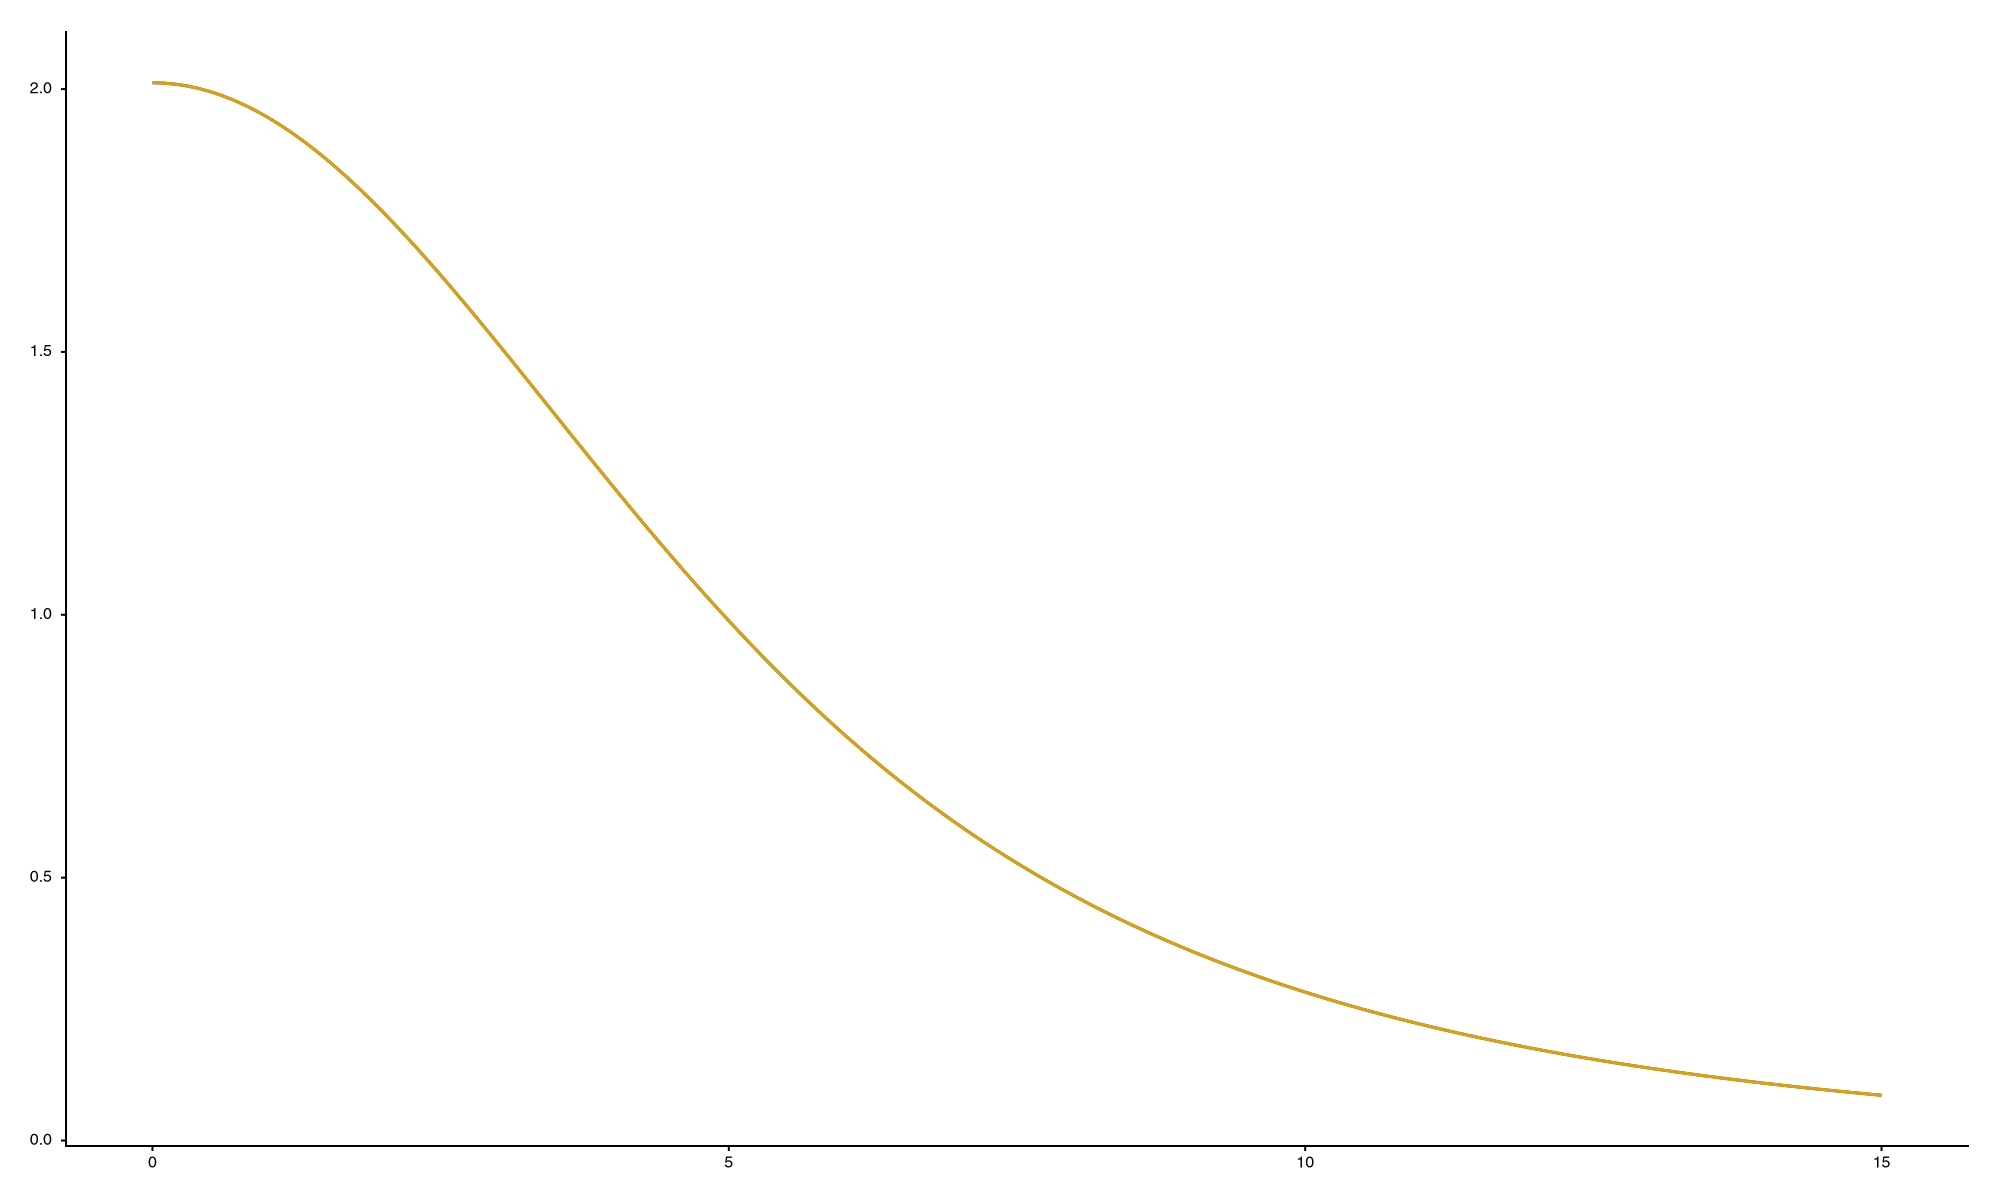

In [7]:
fig = Figure(size = (1000, 600))
ax1 = Axis(fig[1, 1])
x = 0:0.1:15
α = 1
lines!(ax1, x, mrnaprofile,label="Original")
p = fit(x, mrnaprofile, 10)
lines!(ax1, x, p.(x), label="Polynomial")
fig

In [8]:
println(p)

2.01226 - 0.00236644*x - 0.062229*x^2 - 0.00447268*x^3 + 0.00348285*x^4 - 0.000406076*x^5 + 2.37345e-6*x^6 + 3.25029e-6*x^7 - 2.97799e-7*x^8 + 1.13219e-8*x^9 - 1.65008e-10*x^10


In [9]:
maximum(mrna.(x, α, 0.1))

0.2772417942496426

In [10]:
function mirror1(x); [reverse(-x);x]end
function mirror2(x); [reverse(x);x]end

mirror2 (generic function with 1 method)

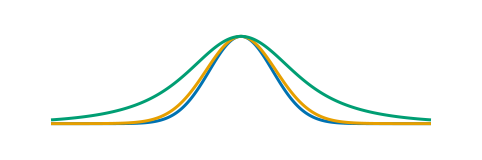

In [11]:
prl_col_size = 8.5
pt_per_cm = 28.3465
fig = Figure(size = (prl_col_size*pt_per_cm, prl_col_size*pt_per_cm*1/3),background_color=:transparent)
ax1 = Axis(fig[1, 1])
x = 0:0.1:15
σ = 2.5
original = mrna.(x, α, getkp(1,α,0.1))
gaussian = exp.(-x .^2 ./(2 * σ^2)) .* original[1]
lines!(ax1, mirror1(x), mirror2(gaussian), label="Locus")
kd = 1/1
α = sqrt(kd/1)
original = mrna.(x, α, getkp(1,α,0.1))
lines!(ax1, mirror1(x), mirror2(original), label="Original")

kd = 1/25
α = sqrt(kd/1)
σ = 2.5
modified = mrna.(x, α, getkp(1,α,0.1))
lines!(ax1, mirror1(x), mirror2(modified), label="Modified")

hidespines!(ax1)
hidedecorations!(ax1)
save("./figures/rnaprofiles.pdf",fig,pt_per_unit=1.0,background_color=:transparent)
fig

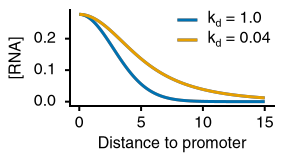

In [12]:
prl_col_size = 8.5
cm = 28.3465
fig = Figure(size = (5cm, 4.25cm*2/3),backgroundcolor=:transparent,figure_padding=5)
ax1 = Axis(fig[1, 1],xlabel="Distance to promoter",ylabel="[RNA]",backgroundcolor=:transparent)
α = 1
x = 0:0.1:15
σ = 2.5
original = mrna.(x, α, getkp(1,α,0.1))
gaussian = exp.(-x .^2 ./(2 * σ^2)) .* original[1]
# lines!(ax1, x, gaussian, label="Locus")
kd = 1/1
α = sqrt(kd/1)
original = mrna.(x, α, getkp(1,α,0.1))
lines!(ax1, x, original, label=rich("k",subscript("d")," = $kd"))
kd = 1/25
α = sqrt(kd/1)
σ = 2.5
modified = mrna.(x, α, getkp(1,α,0.1))
lines!(ax1, x, modified, label=rich("k",subscript("d")," = $kd"))
# hidexdecorations!(ax1, label=false)
# hideydecorations!(ax1, label=false)
axislegend(ax1,framevisible = false, halign=:right,valign=:top,rowgap=-10,linepoints=[Point2f(0.5, 0.5), Point2f(1, 0.5)],
width=60,height=20)
save("./figures/rnaprofiles.pdf",fig,pt_per_unit=1.0,background_color=:transparent)
fig

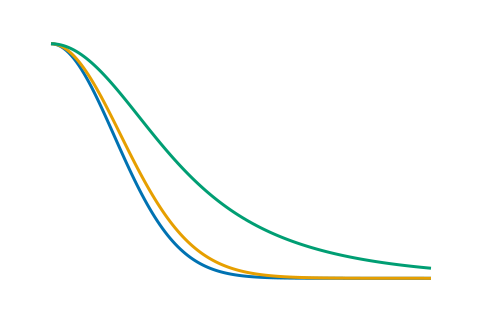

In [13]:
prl_col_size = 8.5
pt_per_cm = 28.3465
fig = Figure(size = (prl_col_size*pt_per_cm, prl_col_size*pt_per_cm*2/3),background_color=:transparent)
ax1 = Axis(fig[1, 1])
x = 0:0.1:15
gaussian = exp.(-x .^2 ./(2 * σ^2)) .* original[1]
lines!(ax1, x, gaussian, label="Locus")
kd = 1
α = sqrt(kd/1)
original = mrna.(x, α, getkp(1,α,0.1))
lines!(ax1, x, original, label="Original")

kd = 1/25
α = sqrt(kd/1)
σ = 2.5
modified = mrna.(x, α, getkp(1,α,0.1))
lines!(ax1, x, modified, label="Modified")

hidespines!(ax1)
hidedecorations!(ax1)
save("./figures/rnaprofiles.pdf",fig,pt_per_unit=1.0,background_color=:transparent)
fig

In [14]:
getkp(1,α,0.1)

0.013779117859431972

In [15]:
getkp(1,α,0.1)

0.013779117859431972

In [16]:
kd = 1/25


0.04

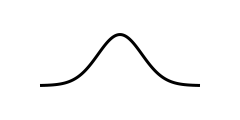

In [17]:
prl_col_size = 8.5
pt_per_cm = 28.3465
fig = Figure(size = (prl_col_size*pt_per_cm/2, prl_col_size*pt_per_cm*1/4),background_color=:transparent)
ax1 = Axis(fig[1, 1])
x = 0:0.1:10
m = mrna.(x,1,0.1)
lines!(ax1, [reverse(-x);x], [reverse(m);m],color="black")
hidespines!(ax1)
hidedecorations!(ax1)
save("./figures/rnaprofile.pdf",fig,pt_per_unit=1.0,background_color=:transparent)
fig

In [18]:
d = 5; R = 2.8; α =1; σ = 2.5; χ = -0.1; Mc = Mm = 1; kp = 0.1; cm = 3.5; cp = 4.5
function f(u,p)
    ϕ₁ = u[1]; r = u[2]; ϕ = u[3]
    R = p[1]; σ = p[2]; d = p[3]; α = p[4]
    return r*R*cos(ϕ)*besselk(0,α*sqrt(R^2+r^2-2*R*r*(cos(ϕ)*cos(ϕ₁)+sin(ϕ)*sin(ϕ₁))))*exp(-(r^2-2*r*cos(ϕ₁)*d+d^2)/(2*σ^2))
end
domain = ([0,0,0], [2*π,Inf,2*π])
p = (R, σ, d, α)
prob = IntegralProblem(f, domain, p)
sol = solve(prob, HCubatureJL(), reltol = 1e-3, abstol = 1e-3)
velocity = (-χ*Mc*kp*cm)/((cp-cm)*π^2*Mm)*sol.u/R^2

0.006229033646333557

In [19]:
function introw(row)
    # Parameters
    Mc = row["Mc"]; Mm = row["Mm"]; χ = row["Chi"]; kp = row["kp"]; kd = row["kd"];
    σ = row["sigma"]; α = row["alpha"]; cplus = row["cplus"]; cminus = row["cminus"];
    # Variables
    R = row["mean_radius"]; d = row["smoothed_distance"]
    # Solution
    b = ([0,0,0], [2*π,Inf,2*π]); p = (R, σ, d, α)
    prob = IntegralProblem(f, b, p)
    sol = solve(prob, HCubatureJL(), reltol = 1e-3, abstol = 1e-3)
    velocity = (-χ*Mc*kp*3.52)/((cplus-3.52)*π^2*Mm)*sol.u/R^2
    return velocity
end

introw (generic function with 1 method)

In [20]:
function introwR(row,R)
    # Parameters
    Mc = row["Mc"]; Mm = row["Mm"]; χ = row["Chi"]; kp = row["kp"]; kd = row["kd"];
    σ = row["sigma"]; α = row["alpha"]; cplus = row["cplus"]; cminus = row["cminus"];
    # Variables
    d = row["smoothed_distance"]
    # Solution
    b = ([0,0,0], [2*π,Inf,2*π]); p = (R, σ, d, α)
    prob = IntegralProblem(f, b, p)
    sol = solve(prob, HCubatureJL(), reltol = 1e-3, abstol = 1e-3)
    velocity = (-χ*Mc*kp*3.52)/((cplus-3.52)*π^2*Mm)*sol.u/R^2
    return velocity
end

introwR (generic function with 1 method)

In [21]:
# Threads.@threads for stats in glob("20240224_FlowPhaseDiagramHighRes/*/flow_stats_100.csv")
#     df = CSV.read(stats, DataFrame)
#     df[!,"analytical_velocity"] = map(introw,eachrow(df))
#     # arr = df[!, "mean_radius"]
#     # avgR = sum(arr)/length(arr)
#     # df[!,"analytical_velocity_avgR"] = map(row -> introwR(row, avgR),eachrow(df))
#     CSV.write(stats, df)
#     print("Done. ")
# end

In [22]:
df = CSV.read("20240224_FlowPhaseDiagramHighRes/M1_1.0_b_-0.25_g_-0.1_c_0.0_k_0.05_kp_0.08_c1_3.53_sw_1.0_sr_2.5_cn_5.5_l_10_M3_0.1_kt_0.0_rl_0.0_wd_0.0_t_0.0_kd_1.0/flow_stats_100.csv", DataFrame)
arr = df[!, "mean_radius"]
avgR = sum(arr)/length(arr)

3.476783035018326

In [23]:
df = CSV.read(glob("08_FreezeRNA/*/flow_stats_100.csv")[2],DataFrame)

Row,time,center_of_mass,eccentricity,variance_of_radius,mean_radius,rna_amount,c_light,c_dense,volume,velocity,aspect,smoothed_distance,smoothed_velocity,Mc,Mm,Chi,kp,kd,sigma,alpha,cplus,cminus,analytical_velocity,analytical_velocity_normV,analytical_velocity_avgR
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64?,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,5879.2,0.150387,0.0908142,0.000354183,3.69676,9.70359,3.50924,4.41,43.7481,missing,1.00415,0.163312,4.58958e-5,1.0,1.0,-0.1,0.07,1.0,2.5,1.0,4.5,3.5,0.000333921,0.0120975,0.000380724
2,5579.2,0.259974,0.104707,0.000174484,3.70046,9.70359,3.50934,4.41129,43.61,-0.000618685,1.00553,0.263276,0.000529434,1.0,1.0,-0.1,0.07,1.0,2.5,1.0,4.5,3.5,0.000536532,0.0194624,0.000612737
3,5409.2,0.362564,0.111071,0.000561516,3.68972,9.70359,3.50933,4.41141,43.61,-0.000557608,0.993812,0.367664,0.000686095,1.0,1.0,-0.1,0.07,1.0,2.5,1.0,4.5,3.5,0.000751635,0.0270918,0.000853417
4,5279.2,0.459035,0.0503253,0.000444601,3.68461,9.70359,3.50937,4.41215,43.5409,-0.000772965,1.00127,0.465516,0.000805013,1.0,1.0,-0.1,0.07,1.0,2.5,1.0,4.5,3.5,0.000951034,0.0341654,0.00107703
5,5179.2,0.544482,0.0918371,0.000668856,3.69245,9.70359,3.50924,4.41057,43.7136,-0.000618228,0.995774,0.561376,0.00104486,1.0,1.0,-0.1,0.07,1.0,2.5,1.0,4.5,3.5,0.0011385,0.0410049,0.00129373
6,5089.2,0.654823,0.135525,0.000418726,3.70172,9.70359,3.50927,4.41089,43.679,-0.00130892,1.00931,0.664836,0.00126954,1.0,1.0,-0.1,0.07,1.0,2.5,1.0,4.5,3.5,0.00133627,0.0482621,0.00152441
7,5019.2,0.748373,0.196357,0.00116601,3.69312,9.70359,3.50923,4.41049,43.7308,-0.00091033,1.01985,0.758046,0.00138524,1.0,1.0,-0.1,0.07,1.0,2.5,1.0,4.5,3.5,0.00152271,0.0546724,0.00172891
8,4949.2,0.853279,0.247984,0.00180928,3.69292,9.70359,3.50921,4.4103,43.7481,-0.00157895,1.03224,0.863047,0.00155083,1.0,1.0,-0.1,0.07,1.0,2.5,1.0,4.5,3.5,0.00172332,0.0617293,0.00195498
9,4889.2,0.956425,0.27553,0.00236804,3.69112,9.70359,3.50928,4.41102,43.6618,-0.00220872,1.04027,0.964238,0.00178703,1.0,1.0,-0.1,0.07,1.0,2.5,1.0,4.5,3.5,0.0019142,0.0683459,0.00216804


In [24]:
function velocity3d(z0)
    R = 1; χ = -1; Mc = 1; kp = 1; cm = 1; cp = 2; l = 1
    function f(u,p)
        x = u[1]
        z0 = p[1]; R = p[2]; l = p[3]
        return x*R^2*exp(-sqrt(R^2+z0^2-2*R*x*z0)/l)/sqrt(R^2+z0^2-2*R*x*z0)
    end
    domain = ([-1], [1])
    p = (z0, R, l)
    prob = IntegralProblem(f, domain, p)
    sol = solve(prob, QuadGKJL(), reltol = 1e-7, abstol = 1e-7)
    velocity = sol.u#*(-3*χ*Mc*kp*cm)/(2*(cp-cm)*4*π*R^3/3)
    return velocity
end

velocity3d (generic function with 1 method)

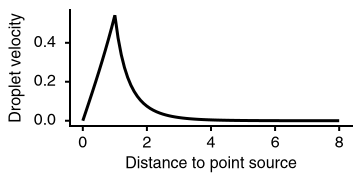

In [25]:
cm = 28.3465
golden = 1.618
fig = Figure(size = (8.5*1.5cm*0.5, 8.5*1.5cm*0.25),background_color=:transparent, figure_padding=5,
backgroundcolor = :transparent)
ax1 = Axis(fig[1, 1],xlabel="Distance to point source",ylabel="Droplet velocity", backgroundcolor = :transparent)
x = 0:0.1:8
# ax1.yticks=[0,0.2,0.4,0.6]
lines!(ax1, x, velocity3d.(x),color="black")
save("./figures/3dvelocity.pdf",fig,pt_per_unit=1.0,background_color=:transparent,dpi=600)
fig

In [26]:
function piecewise(r)
    R = 1; χ = -1; Mc = 1; kp = 1; cm = 1; cp = 2; l = 1
    if r<l
        return exp(-(r+R)/l)*l*(l+r+exp(2*r/l)*(-l+r))*(l+R)/r^2
    else
        return exp(-(r+R)/l)*l*(l+r)*(l+R+exp(2*R/l)*(-l+R))/r^2
    end
end

piecewise (generic function with 1 method)

In [27]:
function velocity3danalytical(d)
    R = 1; χ = -1; Mc = 1; kp = 1; cm = 1; cp = 2; l = 1
    l/d^2*(exp(-(R + d) / l) * (l + R) * (l + d) - exp(-abs(R - d) / l) * (l^2 - R * d + l * abs(R - d)))
end

velocity3danalytical (generic function with 1 method)

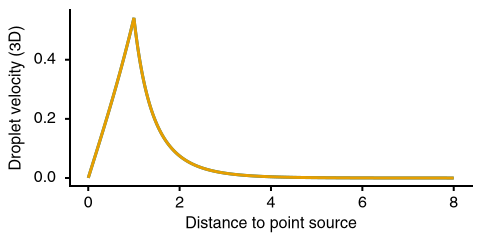

In [28]:
cm = 28.3465
fig = Figure(size = (8.5cm, 8.5cm/2),background_color=:transparent, figure_padding=(5,5,5,5))
ax1 = Axis(fig[1, 1],xlabel="Distance to point source",ylabel="Droplet velocity (3D)")
x = LinRange(0,8,10000)
lines!(ax1, x, velocity3danalytical.(x))
lines!(ax1, x, piecewise.(x))
# save("./figures/3dvelocity.pdf",fig,pt_per_unit=1.0,background_color=:transparent,dpi=600)
fig

In [29]:
function velocity3danalyticalnondim(d)
    R = 1; l = 1
    1/d^2*(exp(-(R + d) / l) * (l + R) * (l + d) - exp(-abs(R - d) / l) * (l^2 - R * d + l * abs(R - d)))
end

velocity3danalyticalnondim (generic function with 1 method)

In [30]:
function energy(r, R, l)
    if r < R 
        return 2*exp(-R/l)*l*(l+R)*(-r+l*sinh(r/l))/r
    else
        return exp(-(r+R)/l)*l*(2*exp((r+R)/l)*l*r+exp(2*R/l)*l*(l-R)-(l+2*exp(r/l)*r)*(l+R))/r
    end
end

energy (generic function with 1 method)

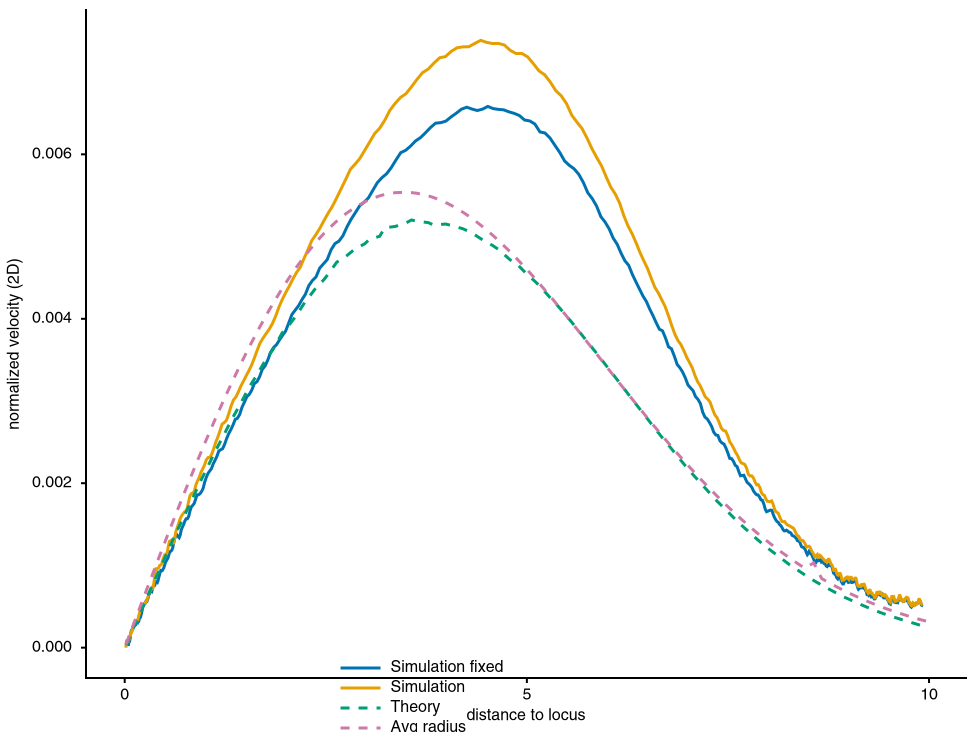

In [31]:
using CairoMakie
using CSV
using DataFrames
using FilePathsBase


prl_col_size_double = 17.2
pt_per_cm = 28.3465
fig = Figure(size = (prl_col_size_double*pt_per_cm*1, prl_col_size_double*pt_per_cm*3/4),background_color=:transparent, figure_padding=(5,5,5,5))
ax = Axis(fig[1,1], title = "", xlabel = "distance to locus", ylabel = "normalized velocity (2D)")

kp = 0.08
c1 = 3.53

simdir = Path("08_FreezeRNA")
simtitle = "M1_1.0_b_-0.25_g_-0.1_c_0.0_k_0.05_kp_$(kp)_c1_$(c1)_sw_1.0_sr_2.5_cn_5.5_l_10_M3_0.1_kt_0.0_rl_0.0_wd_0.0_t_6000.0_kd_1.0"
folder = joinpath(simdir, simtitle)

# Simulations
df = DataFrame(CSV.File(joinpath(folder, "flow_stats.csv")))[16:end, :]
line1 = lines!(ax, df.smoothed_distance, df.smoothed_velocity, label="Simulation fixed")

simdir = Path("20240224_FlowPhaseDiagramHighRes")
simtitle = "M1_1.0_b_-0.25_g_-0.1_c_0.0_k_0.05_kp_$(kp)_c1_$(c1)_sw_1.0_sr_2.5_cn_5.5_l_10_M3_0.1_kt_0.0_rl_0.0_wd_0.0_t_0.0_kd_1.0"
folder = joinpath(simdir, simtitle)

# Simulations
df = DataFrame(CSV.File(joinpath(folder, "flow_stats.csv")))[16:end, :]
line1 = lines!(ax, df.smoothed_distance, df.smoothed_velocity, label="Simulation")

# Analytical
flow_stats_df = DataFrame(CSV.File(joinpath(folder, "flow_stats_100.csv")))
line2 = lines!(ax, flow_stats_df.smoothed_distance, flow_stats_df.analytical_velocity, linestyle = :dash, label="Theory")

# Fixed radius
line2 = lines!(ax, flow_stats_df.smoothed_distance, flow_stats_df.analytical_velocity_avgR, linestyle = :dash, label="Avg radius")


# legend = Legend(fig[1,1], [line1, line2], ["Simulation", "Theory"],framevisible = false,orientation=:horizontal,fontsize=8,padding=[0,0,0,0])
axislegend(ax, fontsize = 8,framevisible = false, padding=[0,0,0,0], rowgap = -10, position=(0.35,-0.15))
save("./figures/2dvelocity.pdf",fig,pt_per_unit=1.0,background_color=:transparent)
fig

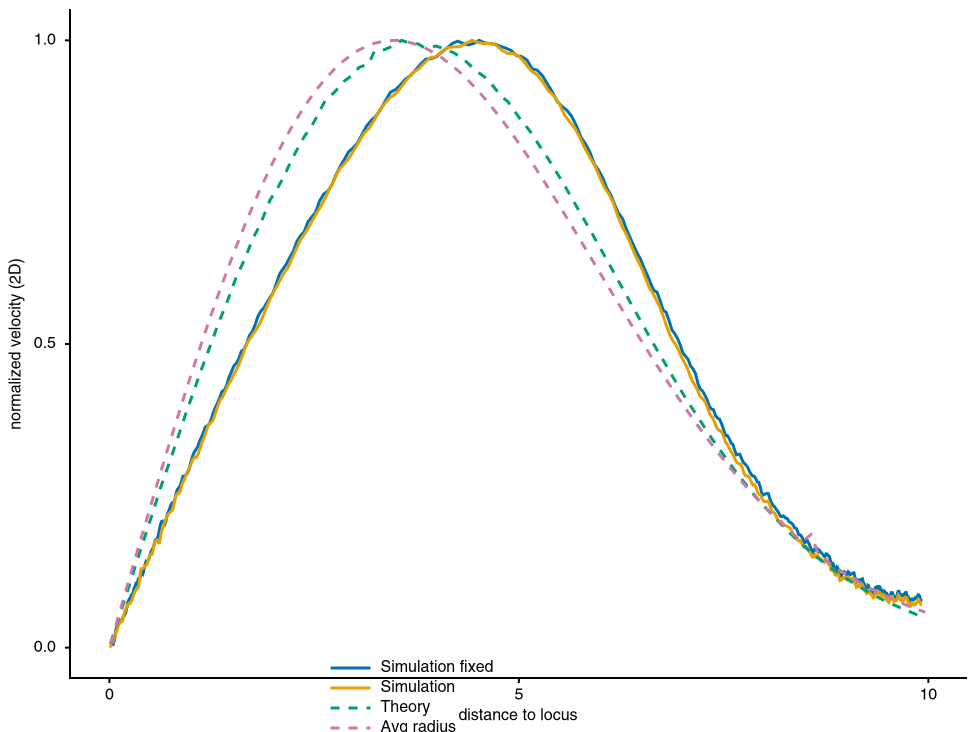

In [32]:
using CairoMakie
using CSV
using DataFrames
using FilePathsBase


prl_col_size_double = 17.2
pt_per_cm = 28.3465
fig = Figure(size = (prl_col_size_double*pt_per_cm*1, prl_col_size_double*pt_per_cm*3/4),background_color=:transparent, figure_padding=(5,5,5,5))
ax = Axis(fig[1,1], title = "", xlabel = "distance to locus", ylabel = "normalized velocity (2D)")

kp = 0.08
c1 = 3.53

simdir = Path("08_FreezeRNA")
simtitle = "M1_1.0_b_-0.25_g_-0.1_c_0.0_k_0.05_kp_$(kp)_c1_$(c1)_sw_1.0_sr_2.5_cn_5.5_l_10_M3_0.1_kt_0.0_rl_0.0_wd_0.0_t_6000.0_kd_1.0"
folder = joinpath(simdir, simtitle)

# Simulations
df = DataFrame(CSV.File(joinpath(folder, "flow_stats.csv")))[16:end, :]
line1 = lines!(ax, df.smoothed_distance, df.smoothed_velocity ./maximum(df.smoothed_velocity), label="Simulation fixed")

simdir = Path("20240224_FlowPhaseDiagramHighRes")
simtitle = "M1_1.0_b_-0.25_g_-0.1_c_0.0_k_0.05_kp_$(kp)_c1_$(c1)_sw_1.0_sr_2.5_cn_5.5_l_10_M3_0.1_kt_0.0_rl_0.0_wd_0.0_t_0.0_kd_1.0"
folder = joinpath(simdir, simtitle)

# Simulations
df = DataFrame(CSV.File(joinpath(folder, "flow_stats.csv")))[16:end, :]
line1 = lines!(ax, df.smoothed_distance, df.smoothed_velocity ./maximum(df.smoothed_velocity), label="Simulation")

# Analytical
flow_stats_df = DataFrame(CSV.File(joinpath(folder, "flow_stats_100.csv")))
line2 = lines!(ax, flow_stats_df.smoothed_distance, flow_stats_df.analytical_velocity ./maximum(flow_stats_df.analytical_velocity), linestyle = :dash, label="Theory")

# Fixed radius
line2 = lines!(ax, flow_stats_df.smoothed_distance, flow_stats_df.analytical_velocity_avgR ./maximum(flow_stats_df.analytical_velocity_avgR), linestyle = :dash, label="Avg radius")


# legend = Legend(fig[1,1], [line1, line2], ["Simulation", "Theory"],framevisible = false,orientation=:horizontal,fontsize=8,padding=[0,0,0,0])
axislegend(ax, fontsize = 8,framevisible = false, padding=[0,0,0,0], rowgap = -10, position=(0.35,-0.15))
save("./figures/2dvelocity.pdf",fig,pt_per_unit=1.0,background_color=:transparent)
fig

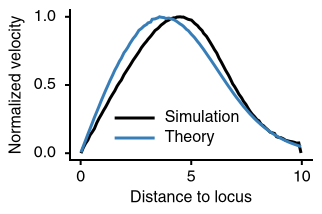

In [33]:
using CairoMakie
using CSV
using DataFrames
using FilePathsBase
using ColorSchemes

fig = Figure(size = (8.5*cm*2/3, 8.5cm*2/3*2/3),background_color=:transparent, figure_padding=(5,5,5,5))
ax = Axis(fig[1,1], title = "", xlabel = "Distance to locus", ylabel = "Normalized velocity")

kp = 0.08
c1 = 3.53

simdir = Path("20240224_FlowPhaseDiagramHighRes")
simtitle = "M1_1.0_b_-0.25_g_-0.1_c_0.0_k_0.05_kp_$(kp)_c1_$(c1)_sw_1.0_sr_2.5_cn_5.5_l_10_M3_0.1_kt_0.0_rl_0.0_wd_0.0_t_0.0_kd_1.0"
folder = joinpath(simdir, simtitle)

# Simulations
df = DataFrame(CSV.File(joinpath(folder, "flow_stats_100.csv")))
line1 = lines!(ax, df.smoothed_distance, df.smoothed_velocity/maximum(df.smoothed_velocity), label="Simulation",
color="black")

# Analytical
flow_stats_df = DataFrame(CSV.File(joinpath(folder, "flow_stats_100.csv")))
line2 = lines!(ax, flow_stats_df.smoothed_distance, flow_stats_df.analytical_velocity/maximum(flow_stats_df.analytical_velocity), label="Theory"
,color=ColorSchemes.Set1_3[2])

# # Fixed radius
# line2 = lines!(ax, flow_stats_df.smoothed_distance, flow_stats_df.analytical_velocity_avgR, linestyle = :dash, label="Avg radius")


# legend = Legend(fig[1,1], [line1, line2], ["Simulation", "Theory"],framevisible = false,orientation=:horizontal,fontsize=8,padding=[0,0,0,0])
axislegend(ax, fontsize = 8,framevisible = false, padding=[0,0,0,0], rowgap = -10, position=(0.35,-0.15))
save("./figures/2dvelocity.pdf",fig,pt_per_unit=1.0,background_color=:transparent)
fig